# Capstone Project
## Definition
### Project Overview
My project is my code for the [Kaggle Shelter Animal Outcomes contest](https://www.kaggle.com/c/shelter-animal-outcomes).  As described on the Kaggle site:
>Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

### Problem Statement
As described on the Kaggle site:
>Using a dataset of intake information including breed, color, sex, and age from the 
> [Austin Animal Center](http://www.austintexas.gov/department/animal-services), 
> we're asking Kagglers to predict the outcome for each animal.

### Metrics
> <p>Submissions are evaluated using the <a href="https://www.kaggle.com/wiki/MultiClassLogLoss">multi-class logarithmic loss</a>. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class). The formula is then,</p>
> <p>$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),$$</p>
> <p>where N is the number of animals in the test set, M is the number of outcomes, \\(log\\) is the natural logarithm, \\(y_{ij}\\) is 1 if observation \\(i\\) is in outcome \\(j\\) and 0 otherwise, and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to outcome \\(j\\).</p>
> <p>The submitted probabilities for a given animal are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).</p>


## Analysis
### Data Exploration

In [2]:
%matplotlib inline
import pandas as pd 

data = pd.read_csv('../data/train.csv')
print data.head()

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4      

### Exploratory Visualization

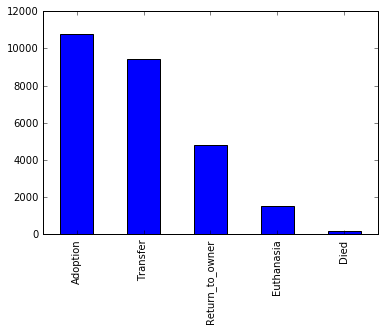

In [6]:
data['OutcomeType'].value_counts().plot(kind='bar')

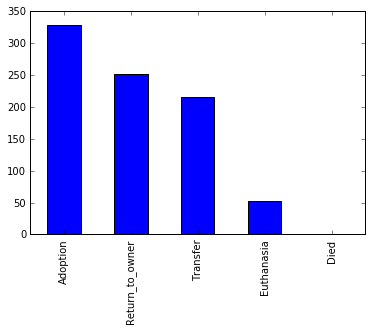

In [7]:
black = data['AnimalType'] == "Dog"
dog = data['Color'] == "Black"
black_dogs = data[black & dog]
black_dogs.head()
black_dogs['OutcomeType'].value_counts().plot(kind='bar')

### Algorithms and Techniques
### Benchmark
## Methodology
## Results
## Conclusion